In [1]:
import os, getpass
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from langgraph.graph import START, StateGraph, MessagesState
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

def check_tyre_wear(lap_number: int) -> str:
    """Checks the estimated tyre wear based on the current lap number."""
    if lap_number < 15:
        return f"Lap {lap_number}: Tyre wear is low. Estimated 85% life remaining."
    elif lap_number < 30:
        return f"Lap {lap_number}: Tyre wear is medium. Estimated 50% life remaining."
    else:
        return f"Lap {lap_number}: Tyre wear is high. Estimated 20% life remaining. Consider pitting."

def get_weather_forecast(sector: int) -> str:
    """Gets the weather forecast for a specific sector of the track."""
    if sector == 1:
        return f"Sector {sector}: Forecast is clear, track temperature stable."
    elif sector == 2:
        return f"Sector {sector}: Slight chance of light drizzle in the next 10 laps."
    else:
        return f"Sector {sector}: Track remains dry for now."

def suggest_pit_strategy(current_lap: int, laps_remaining: int) -> str:
    """Suggests a pit stop strategy based on current lap and laps remaining."""
    optimal_pit_window_start = 20
    optimal_pit_window_end = 35
    if optimal_pit_window_start <= current_lap <= optimal_pit_window_end:
        return f"Lap {current_lap}/{laps_remaining} laps remaining: Currently within the optimal pit window. Evaluate traffic."
    elif current_lap < optimal_pit_window_start:
        return f"Lap {current_lap}/{laps_remaining} laps remaining: Too early for optimal one-stop. Hold position."
    else:
        return f"Lap {current_lap}/{laps_remaining} laps remaining: Past optimal window. Consider Plan B if tyres degrade rapidly."

tools = [check_tyre_wear, get_weather_forecast, suggest_pit_strategy]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

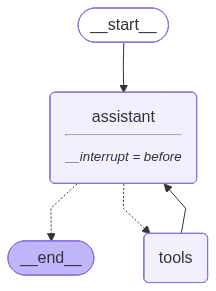

In [3]:
sys_msg = SystemMessage(content="You are a helpful F1 race engineer providing concise updates and strategy advice to the driver based on available tools.")

def race_engineer_assistant(state: MessagesState):
   """Invokes the LLM with the current message state and system prompt."""
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

builder = StateGraph(MessagesState)

builder.add_node("assistant", race_engineer_assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [4]:
initial_input = {"messages": [HumanMessage(content="What's the tyre wear like on lap 25?")]}

thread = {"configurable": {"thread_id": "f1_edit_1"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    if "messages" in event:
        event['messages'][-1].pretty_print()

================================ Human Message =================================

What's the tyre wear like on lap 25?


In [5]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content="What's the tyre wear like on lap 25?", additional_kwargs={}, response_metadata={}, id='e5235252-e69a-481d-8950-1bc9742a45b2')]}, next=('assistant',), config={'configurable': {'thread_id': 'f1_edit_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0afc92-f55c-6720-8000-bf6d05a6df06'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-23T04:31:46.592330+00:00', parent_config={'configurable': {'thread_id': 'f1_edit_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0afc92-f55b-6064-bfff-5ae7282beef2'}}, tasks=(PregelTask(id='a2a8ebe5-048a-48fc-661e-5a63d83960ac', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [6]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="Actually, check wear for lap 12.")]},
)

{'configurable': {'thread_id': 'f1_edit_1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0afc92-f57f-6aae-8001-37ab3db1aa9f'}}

In [7]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

What's the tyre wear like on lap 25?
================================ Human Message =================================

Actually, check wear for lap 12.


In [8]:
for event in graph.stream(None, thread, stream_mode="values"):
     if "messages" in event:
        event['messages'][-1].pretty_print()

================================ Human Message =================================

Actually, check wear for lap 12.
================================== Ai Message ==================================
Tool Calls:
  check_tyre_wear (call_IVRcJWbKPkNO1w3fbgEQf3OH)
 Call ID: call_IVRcJWbKPkNO1w3fbgEQf3OH
  Args:
    lap_number: 12
================================= Tool Message =================================
Name: check_tyre_wear

Lap 12: Tyre wear is low. Estimated 85% life remaining.


In [9]:
for event in graph.stream(None, thread, stream_mode="values"):
     if "messages" in event:
        event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: check_tyre_wear

Lap 12: Tyre wear is low. Estimated 85% life remaining.
================================== Ai Message ==================================

Tyre wear on lap 12 is low, with an estimated 85% life remaining.


In [10]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [11]:
# This is the URL of the local development server
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

In [12]:
initial_input = {"messages": [HumanMessage(content="Lap 10, check tyre wear.")]}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    "f1_race_data",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Lap 10, check tyre wear.', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '3a6ed01b-0866-42d7-9d06-8ba2349aba47'}
--------------------------------------------------


In [13]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'messages': [{'content': 'Lap 10, check tyre wear.',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '3a6ed01b-0866-42d7-9d06-8ba2349aba47'}]},
 'next': ['assistant'],
 'tasks': [{'id': '11dc50df-f68e-e39a-9d7e-8d9584c621f2',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': None}],
 'metadata': {'langgraph_auth_user': None,
  'langgraph_auth_user_id': '',
  'langgraph_auth_permissions': [],
  'langgraph_request_id': '5fd43a49-62d6-4279-b3ce-8986624686af',
  'graph_id': 'f1_race_data',
  'assistant_id': '925333f2-6df8-5b33-8365-b2f75b18da00',
  'user_id': '',
  'created_by': 'system',
  'run_attempt': 1,
  'langgraph_version': '1.0.1',
  'langgraph_api_version': '0.4.42',
  'langgraph_plan': 'developer',
  'langgraph_host': 'self-hosted',
  'langgraph_api_url': 'http://127.0.0.1:2024',
  'run_id': '019a0f56-

In [14]:
last_message = current_state['values']['messages'][-1]
last_message

{'content': 'Lap 10, check tyre wear.',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '3a6ed01b-0866-42d7-9d06-8ba2349aba47'}

In [15]:
last_message['content'] = "Forget lap 10, check lap 28 wear instead."
last_message

{'content': 'Forget lap 10, check lap 28 wear instead.',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '3a6ed01b-0866-42d7-9d06-8ba2349aba47'}

In [16]:
last_message

{'content': 'Forget lap 10, check lap 28 wear instead.',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '3a6ed01b-0866-42d7-9d06-8ba2349aba47'}

In [17]:
await client.threads.update_state(thread['thread_id'], {"messages": last_message})

{'checkpoint': {'thread_id': '62aa2bd2-b102-40c7-a3b4-0b9ec6f92de9',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0afc93-0c90-6158-8001-0d712630cf28'},
 'configurable': {'thread_id': '62aa2bd2-b102-40c7-a3b4-0b9ec6f92de9',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0afc93-0c90-6158-8001-0d712630cf28'},
 'checkpoint_id': '1f0afc93-0c90-6158-8001-0d712630cf28'}

In [18]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="f1_race_data",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Forget lap 10, check lap 28 wear instead.', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '3a6ed01b-0866-42d7-9d06-8ba2349aba47'}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 18, 'prompt_tokens': 152, 'total_tokens': 170, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CThHK4z2GvLTjySxyMGWuLYiTUnrF', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 

In [19]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="f1_race_data",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Lap 28: Tyre wear is medium. Estimated 50% life remaining.', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'check_tyre_wear', 'id': '7c271fb1-cf81-4c27-8c2b-9e7ad8a61cb4', 'tool_call_id': 'call_y3LCYVhJBBE9tLuGfIHq8Edg', 'artifact': None, 'status': 'success'}
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Tyre wear on lap 28 is at a medium level with an estimated 50% life remaining. Let me know if you need any strategy advice or weather updates.', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 35, 'prompt_tokens': 198, 'total_tokens': 233, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_to